In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import qiskit

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy

from PIL import Image

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-10-12 13:37:57,359: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
# Loading our image in the Quantum State
test_image = Image.open('test_4x4_image.tif')
np_test_image = np.array(test_image)

# We need to do this so that we take only a single channel of the color data in the .tif image
test_image_final = []
for row in np_test_image:
    for pixel in row:
        test_image_final.append( pixel[0] / 256)

np_test_image = np.array(test_image_final)

np_test_image = np_test_image.reshape((4,4))
print(np_test_image)


[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]


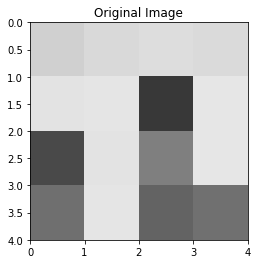

In [4]:
# Function to plot our image
def plot_image4x4(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image4x4(np_test_image, "Original Image")   

[[0.2778443  0.2898664  0.29520956 0.29120219]
 [0.3032243  0.30589588 0.07614002 0.30723167]
 [0.09884845 0.30456009 0.16964532 0.30723167]
 [0.14827268 0.30589588 0.1322432  0.14960847]]


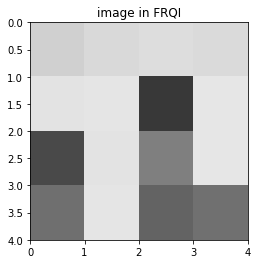

In [5]:
# We need to normalize our input image before passing it as the input quantum state.
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array

# The normalized image is too dark, so we brighten it with this method
def plot_image4x4_brightened(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=0.34, cmap='gray')
    plt.show()
    
def plot_image4x4_denormalized(image, true_image, true_image_normalized, title: str):
    normalization_factor = 0.0
    for x in range(4):
        for y in range(4):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (4**2)
    
    image_plot = image / normalization_factor
    
    plt.title(title)
    plt.imshow(image_plot, extent=[0, 4, 4, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    

np_test_image_normalized = normalize(np_test_image)
print(np_test_image_normalized)

plot_image4x4_denormalized(np_test_image, np_test_image_normalized, np_test_image_normalized, 'image in FRQI')

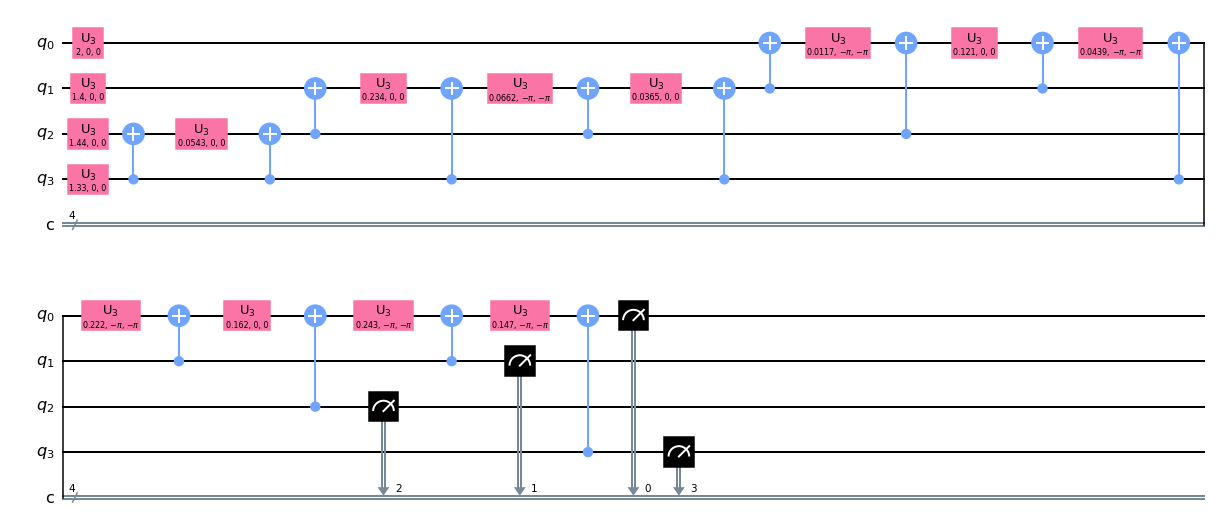

In [6]:
# Our Quantum Circuit that initializes the FRQI image
qc_image = QuantumCircuit(4,4)

qc_image.initialize(np_test_image_normalized.reshape(16))

qc_image.measure(range(4), range(4))

#qc_image = qc_image.decompose().decompose().decompose().decompose().decompose().decompose().decompose()
qc_image = qiskit.compiler.transpile(qc_image, basis_gates=["u1", "u2", "u3", "cx"])


qc_image.draw()

In [7]:
import sys
!{sys.executable} -m pip install mitiq

  Using cached mitiq-0.19.0-py3-none-any.whl (144 kB)
  Using cached cirq-1.0.0-py3-none-any.whl (7.8 kB)
  Using cached numpy-1.21.6-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
     |████████████████████████████████| 33.8 MB 82 kB/s s eta 0:00:01    |████████████████                | 16.9 MB 25.8 MB/s eta 0:00:01��            | 20.7 MB 25.8 MB/s eta 0:00:01     | 25.0 MB 25.8 MB/s eta 0:00:01�████████▋     | 28.1 MB 25.8 MB/s eta 0:00:01
  Using cached cirq_ionq-1.0.0-py3-none-any.whl (57 kB)
  Using cached cirq_web-1.0.0-py3-none-any.whl (594 kB)
  Using cached cirq_pasqal-1.0.0-py3-none-any.whl (31 kB)
  Using cached cirq_rigetti-1.0.0-py3-none-any.whl (66 kB)
  Using cached cirq_google-1.0.0-py3-none-any.whl (576 kB)
  Using cached cirq_core-1.0.0-py3-none-any.whl (1.8 MB)
  Using cached cirq_aqt-1.0.0-py3-none-any.whl (27 kB)
  Using cached duet-0.2.7-py3-none-any.whl (28 kB)
     |████████████████████████████████| 115 kB 55.0 MB/s eta 0:00:01
  Using cached

In [8]:
# Importing mitiq and curve fitting
import mitiq
from qiskit.test.mock import FakeLima
from qiskit.providers.aer.noise import NoiseModel
from mitiq import zne

from scipy.optimize import curve_fit

/tmp/ipykernel_96/2602818812.py:3: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeLima


In [9]:
# The simple ZNE function that comes with mitiq only supports a single float output 
# Since we want to recreate an entire image, I had to recreate the method in a lower level

#Factors to adjust noise
scale_factors = [1., 1.5, 2., 2.5, 3.]
# Generating a bunch of noiser circuits
folded_circuits = [
        mitiq.zne.scaling.folding.fold_all(
        qc_image, scale) for scale in scale_factors
]

shots = 4000
noisy_backend = FakeLima()

job = qiskit.execute(
   experiments=folded_circuits,
   backend=noisy_backend,
   optimization_level=1,
   shots=shots
)


In [10]:
# Lambda to convert between integer and it's binary string representation
get_bin = lambda x, n: format(x, 'b').zfill(n)

# Linear Fit
def linear_function(x, a, b):
    return a + (b * x)

zne_output = []

all_counts = [job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = []
for i in range(16):
    expectation_values.append([np.sqrt((counts.get(get_bin(i, 4)) / shots)) for counts in all_counts])
    
for i in range(16):
    # Fitting the curve to the data points to extrapolate ZNE output
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[i])
    zne_output.append(linear_function(0, param[0], param[1]))
    
print(zne_output)

[0.42040702209963965, 0.37115362620620684, 0.3767432755016678, 0.40289794985757865, 0.24443008224120166, 0.2347886010323571, 0.11146605089638509, 0.23728462498916425, 0.1114872330619916, 0.23280273369791338, 0.14893986770212453, 0.21466678833566302, 0.1251641515254711, 0.21334924118571974, 0.10496533343769787, 0.12275833670617486]


[[0.42040702 0.37115363 0.37674328 0.40289795]
 [0.24443008 0.2347886  0.11146605 0.23728462]
 [0.11148723 0.23280273 0.14893987 0.21466679]
 [0.12516415 0.21334924 0.10496533 0.12275834]]


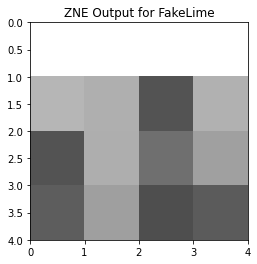

In [11]:
np_zne_output = np.array(zne_output)

np_zne_output = np_zne_output.reshape((4,4))
print(np_zne_output)

plot_image4x4_denormalized(np_zne_output, np_test_image, np_test_image_normalized, 'ZNE Output for FakeLime')

In [12]:
simulator_output = [0.2770379, 0.29197603, 0.29874738, 0.28504386,
 0.29453353, 0.30248967, 0.06123724, 0.31104662,
 0.09082951, 0.31424513, 0.16881943, 0.31064449,
 0.14491377, 0.30618622, 0.14230249, 0.14747881]
np_simulator_output = np.array(simulator_output).reshape((4,4))
print(np_simulator_output)

[[0.2770379  0.29197603 0.29874738 0.28504386]
 [0.29453353 0.30248967 0.06123724 0.31104662]
 [0.09082951 0.31424513 0.16881943 0.31064449]
 [0.14491377 0.30618622 0.14230249 0.14747881]]


[[0.38632888 0.34387498 0.34532593 0.35071356]
 [0.25641763 0.26172505 0.12649111 0.23345235]
 [0.1396424  0.26124701 0.16583124 0.24083189]
 [0.13322913 0.24799194 0.1161895  0.1396424 ]]


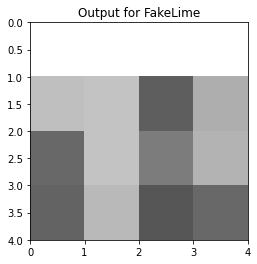

In [13]:
fake_lima_output = []
for i in range(16):
    fake_lima_output.append(expectation_values[i][0])

np_fake_lima_output = np.array(fake_lima_output).reshape((4,4))
print(np_fake_lima_output)

plot_image4x4_denormalized(np_fake_lima_output, np_test_image, np_test_image_normalized, 'Output for FakeLime')

In [14]:
# Calculating Error:
def un_normalize(true_image, true_image_normalized, image, n):
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image

def rmse_image_error(true_image, error_image, n):
    rms_error = 0.0
    for y in range(n):
        for x in range(n):
            rms_error += ((true_image[y][x] - error_image[y][x]) ** 2)
            
    rms_error = np.sqrt(rms_error)
    return (rms_error / (n**2))

rmse_simulator = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_simulator_output, 4), 4)
rmse_fake_lima = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_fake_lima_output, 4), 4) 
rmse_zne = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 4), 4) 

print("Simulator error: ", (rmse_simulator * 100), "% per pixel")
print("FakeLima error: ", (rmse_fake_lima * 100), "% per pixel")
print("FakeLima with ZNE error: ", (rmse_zne * 100), "% per pixel")

Simulator error:  0.4719698542319386 % per pixel
FakeLima error:  3.8667358325385695 % per pixel
FakeLima with ZNE error:  5.3466862438254985 % per pixel


In [25]:
# Let's Run it on IBMQ_Kolkata!
scale_factors = [1., 1.5, 2., 2.5, 3.]
folded_circuits = [
        mitiq.zne.scaling.folding.fold_all(
        qc_image, scale) for scale in scale_factors
]

shots = 4000

# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
print("Chosen Backend: ", backend_kolkata)

job = qiskit.execute(
   experiments=folded_circuits,
   backend=backend_kolkata,
   optimization_level=2,  # We're adding our own error, so we don't want qiskit to optimize anything!
   shots=shots
)

ibmqfactory.load_account:WARNING:2022-10-12 13:47:46,024: Credentials are already in use. The existing account in the session will be replaced.


Chosen Backend:  ibmq_kolkata


In [30]:
#We're running on ibmq_kolkata Job_ID: 6346c588aa9d8fa17c54e801
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
kolkata_job = backend_kolkata.retrieve_job('6346c588aa9d8fa17c54e801')

print(kolkata_job)

ibmqfactory.load_account:WARNING:2022-10-12 13:49:31,141: Credentials are already in use. The existing account in the session will be replaced.


In [31]:
get_bin = lambda x, n: format(x, 'b').zfill(n)

def linear_function(x, a, b):
    return a + (b * x)

zne_output = []

all_counts = [kolkata_job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = []
for i in range(16):
    expectation_values.append([np.sqrt((counts.get(get_bin(i, 4)) / shots)) for counts in all_counts])
    
for i in range(16):
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[i])
    zne_output.append(linear_function(0, param[0], param[1]))
    
print(zne_output)

[0.33082318757835116, 0.3249818666713472, 0.2783038402409814, 0.29555466458592994, 0.2969033812982145, 0.3174014716763305, 0.11652291389426794, 0.30107266644713826, 0.1034796155224248, 0.261498906820228, 0.18852761334161405, 0.2635166333797422, 0.1335980821732934, 0.28958531878948346, 0.12657034264578726, 0.15435409846665882]


[[0.33082319 0.32498187 0.27830384 0.29555466]
 [0.29690338 0.31740147 0.11652291 0.30107267]
 [0.10347962 0.26149891 0.18852761 0.26351663]
 [0.13359808 0.28958532 0.12657034 0.1543541 ]]


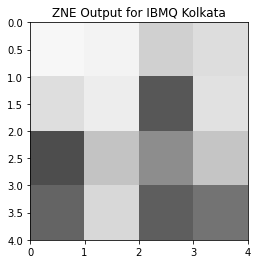

In [32]:
np_zne_output = np.array(zne_output)

np_zne_output = np_zne_output.reshape((4,4))
print(np_zne_output)

plot_image4x4_denormalized(np_zne_output, np_test_image, np_test_image_normalized, 'ZNE Output for IBMQ Kolkata')

[[0.34095454 0.2936835  0.27248853 0.28284271]
 [0.31424513 0.33316662 0.10368221 0.2974895 ]
 [0.1183216  0.27793884 0.18506756 0.25932605]
 [0.13228757 0.28722813 0.13693064 0.15083103]]


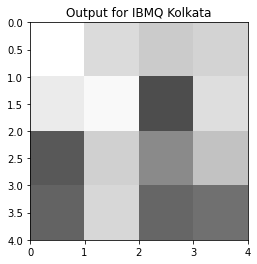

In [33]:
kolkata_output = []
for i in range(16):
    kolkata_output.append(expectation_values[i][0])

np_kolkata_output = np.array(kolkata_output).reshape((4,4))
print(np_kolkata_output)

plot_image4x4_denormalized(np_kolkata_output, np_test_image, np_test_image_normalized, 'Output for IBMQ Kolkata')

In [35]:
def un_normalize(true_image, true_image_normalized, image, n):
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image

def rmse_image_error(true_image, error_image, n):
    rms_error = 0.0
    for y in range(n):
        for x in range(n):
            rms_error += ((true_image[y][x] - error_image[y][x]) ** 2)
            
    rms_error = np.sqrt(rms_error)
    return (rms_error / (n**2))

rmse_simulator = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_simulator_output, 4), 4)
rmse_kolkata = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 4), 4) 
rmse_zne = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 4), 4) 

print("Simulator error: ", (rmse_simulator * 100), "% per pixel")
print("IBMQ Kolkata error: ", (rmse_kolkata * 100), "% per pixel")
print("IMBQ Kolkata (with ZNE) error: ", (rmse_zne * 100), "% per pixel")

Simulator error:  0.4719698542319386 % per pixel
IBMQ Kolkata error:  1.8773113939820074 % per pixel
IMBQ Kolkata (with ZNE) error:  1.9050946857613482 % per pixel


In [22]:
print("True Image:")
print(np_test_image)
print("IBMQ Kolkata:")
print(un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 4))
print("IBMQ Kolkata with ZNE:")
print(un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 4))

True Image:
[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]
IBMQ Kolkata:
[[1.07545074 1.07545074 0.63901135 0.83994115]
 [0.83866755 0.88093771 0.32366067 0.65225652]
 [0.43374375 0.93737378 0.40835623 0.73834949]
 [0.51694804 0.88093771 0.38128204 0.38407535]]
IBMQ Kolkata with ZNE:
[[1.23170455 1.15410708 0.30182017 0.85107496]
 [1.00887506 1.02777097 0.38289394 0.52928714]
 [0.11935086 0.94776401 0.50237119 0.72460882]
 [0.61251256 0.85658002 0.43007562 0.43341733]]


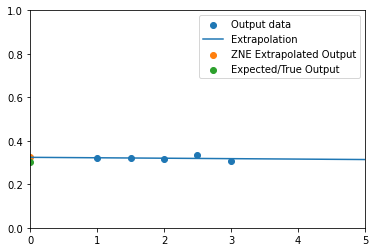

In [23]:
# We want to figure out why applying ZNE made things worse.
# Let's do it for pixel 0000:
plt.xlim([0, 5])
plt.ylim([0,1])

scale_factors_fitted = np.linspace(0, 5, 100)

plt.scatter(scale_factors, expectation_values[9], label="Output data")

param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[9])

def lin_temp(x):
    return param[0] + (param[1] * x)

plt.plot(scale_factors_fitted, lin_temp(scale_factors_fitted), label="Extrapolation" )

plt.scatter(0, lin_temp(0), label="ZNE Extrapolated Output")
plt.scatter(0, np_test_image_normalized[2][1], label="Expected/True Output")

plt.legend()

plt.show()

In [24]:
def linear_function(x, a, b):
    return a + (b * x)

def plot_pixel_error_linear(scale_factors, expectation_values, test_image_normalized, x, y, n):
    plt.xlim([0, 5])
    plt.ylim([0,1])

    scale_factors_fitted = np.linspace(0, 5, 100)

    plt.scatter(scale_factors, expectation_values[x + (y * n)], label="Output data")
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[x + (y * n)])
    
    scale_factors_fitted_output = []
    for x_output in scale_factors_fitted:
        scale_factors_fitted_output.append(linear_function(x_output, param[0], param[1]))
        
    np_scale_factors_fitted_output = np.array(scale_factors_fitted_output)
    plt.plot(scale_factors_fitted, np_scale_factors_fitted_output, label="Extrapolation" )

    plt.scatter(0, linear_function(0, param[0], param[1]), label="ZNE Extrapolated Output")
    plt.scatter(0, test_image_normalized[y][x], label="Expected/True Output")

    plt.title("Pixel Error Data for (" + str(x) + ", " + str(y) + ")")
    plt.legend()
    plt.show()

    
x = 1
y = 2
print(np_test_image_normalized[2][1])
print(type(np_test_image_normalized[2][1]))

0.30456009342437135
<class 'numpy.float64'>


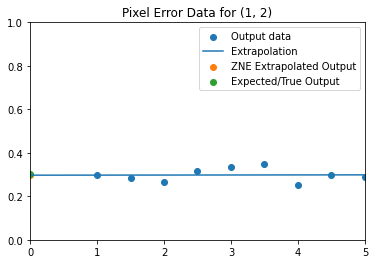

In [83]:
plot_pixel_error_linear(scale_factors, expectation_values, np_test_image_normalized, 1, 2, 4)

In [54]:
#We'll take another set of errors, and many more shots:
scale_factors = [1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5]
folded_circuits = [
        mitiq.zne.scaling.folding.fold_all(
        qc_image, scale) for scale in scale_factors
]

shots = 16000

# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
print("Chosen Backend: ", backend_kolkata)

job = qiskit.execute(
   experiments=folded_circuits,
   backend=backend_kolkata,
   optimization_level=0,
   #initial_layout=[12,15,13,10],
   shots=shots
)

ibmqfactory.load_account:WARNING:2022-10-12 14:44:10,055: Credentials are already in use. The existing account in the session will be replaced.


Chosen Backend:  ibmq_kolkata


In [55]:
# we ran this job on ibmq_kolkata job_id=6346d2c2ea97ba7159e187dd
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
kolkata_job = backend_kolkata.retrieve_job('6346d2c2ea97ba7159e187dd')

print(kolkata_job)

ibmqfactory.load_account:WARNING:2022-10-12 14:45:03,473: Credentials are already in use. The existing account in the session will be replaced.


In [56]:
get_bin = lambda x, n: format(x, 'b').zfill(n)

def linear_function(x, a, b):
    return a + (b * x)

zne_output = []

all_counts = [kolkata_job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = []
for i in range(16):
    expectation_values.append([np.sqrt((counts.get(get_bin(i, 4)) / shots)) for counts in all_counts])
    
for i in range(16):
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[i])
    zne_output.append(linear_function(0, param[0], param[1]))
    


np_zne_output = np.array(zne_output).reshape((4,4))

kolkata_output = []
for i in range(16):
    kolkata_output.append(expectation_values[i][0])
np_kolkata_output = np.array(kolkata_output).reshape((4,4))

print(np_zne_output)
print(np_kolkata_output)


[[0.30000147 0.31347988 0.28650932 0.34829949]
 [0.30633531 0.29870871 0.14234581 0.29724297]
 [0.15631085 0.28546642 0.1537805  0.25840559]
 [0.14939757 0.25212045 0.12101016 0.14875531]]
[[0.30659419 0.325      0.26867732 0.32365105]
 [0.30639027 0.29336411 0.12574776 0.25787594]
 [0.18251712 0.29801426 0.15850867 0.28482451]
 [0.16007811 0.26657551 0.12144958 0.14620192]]


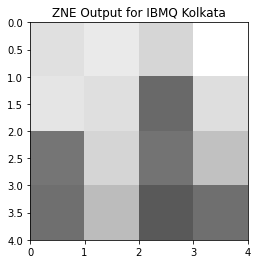

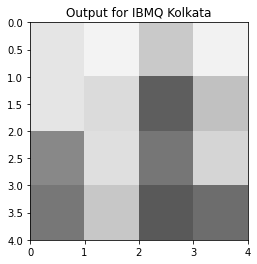

In [57]:
plot_image4x4_denormalized(np_zne_output, np_test_image, np_test_image_normalized, 'ZNE Output for IBMQ Kolkata')
plot_image4x4_denormalized(np_kolkata_output, np_test_image, np_test_image_normalized, 'Output for IBMQ Kolkata')

In [58]:
print("True Image:")
print(np_test_image)
print("IBMQ Kolkata:")
print(un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 4))
print("IBMQ Kolkata with ZNE:")
print(un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 4))

rmse_simulator = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_simulator_output, 4), 4)
rmse_kolkata = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 4), 4) 
rmse_zne = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 4), 4) 

print("Simulator error: ", (rmse_simulator * 100), "% per pixel")
print("IBMQ Kolkata error: ", (rmse_kolkata * 100), "% per pixel")
print("IMBQ Kolkata (with ZNE) error: ", (rmse_zne * 100), "% per pixel")

True Image:
[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]
IBMQ Kolkata:
[[0.89657332 0.95039741 0.785693   0.94645267]
 [0.895977   0.85788458 0.36772415 0.75410654]
 [0.53373477 0.87148303 0.46352688 0.83291223]
 [0.46811636 0.77954668 0.35515497 0.42753822]]
IBMQ Kolkata with ZNE:
[[0.87729423 0.91670914 0.83783914 1.01853211]
 [0.89581627 0.87351379 0.41626182 0.86922755]
 [0.45709977 0.83478938 0.44970027 0.75565541]
 [0.43688327 0.73727578 0.35386998 0.43500513]]
Simulator error:  0.4719698542319386 % per pixel
IBMQ Kolkata error:  2.476820948596891 % per pixel
IMBQ Kolkata (with ZNE) error:  2.4691231935393807 % per pixel


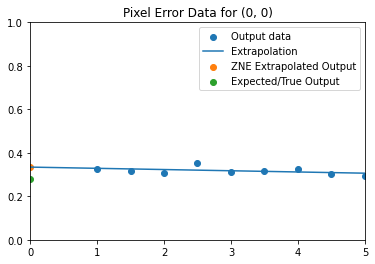

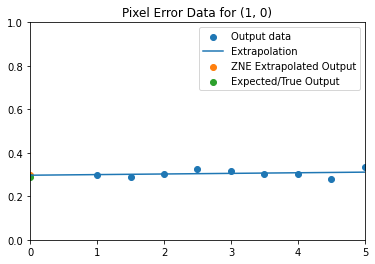

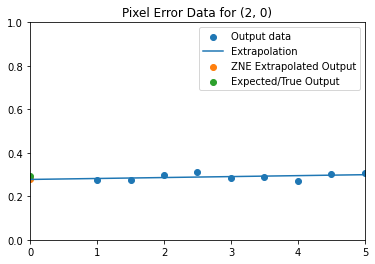

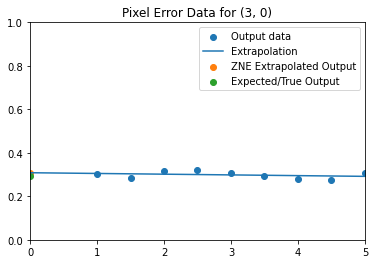

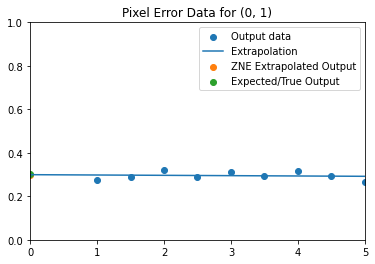

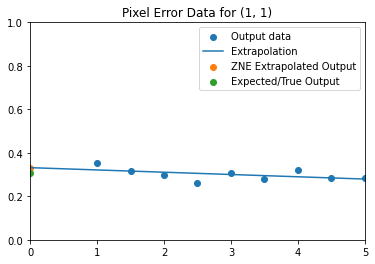

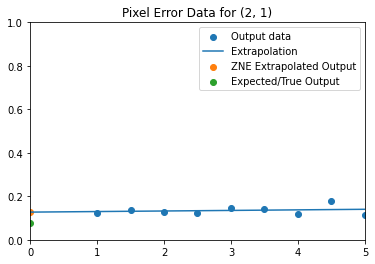

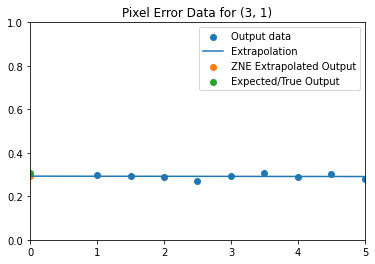

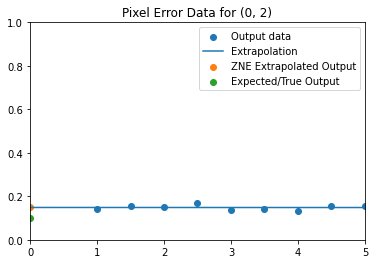

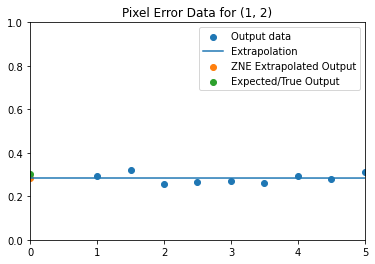

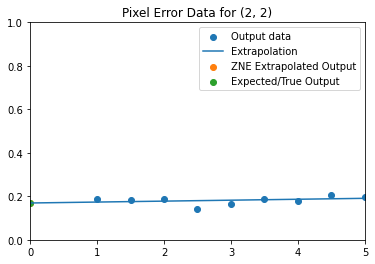

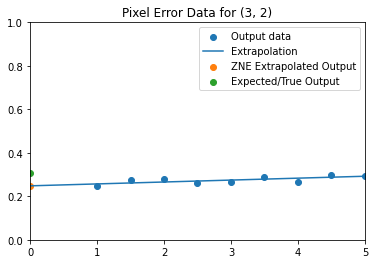

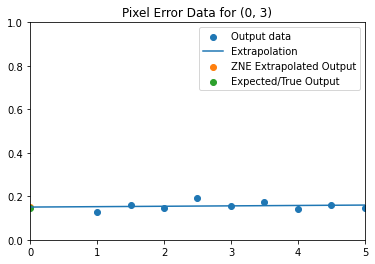

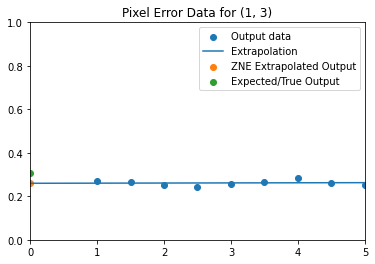

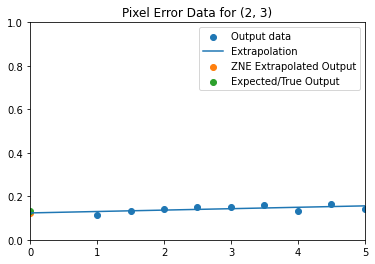

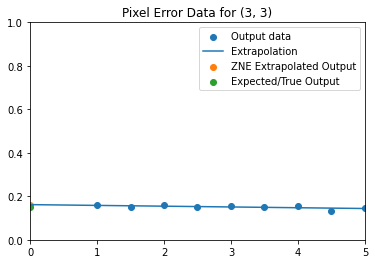

In [41]:
for y in range(4):
    for x in range(4):
        plot_pixel_error_linear(scale_factors, expectation_values, np_test_image_normalized, x, y, 4)

In [14]:
def un_normalize(true_image, true_image_normalized, image, n):
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image

def rmse_image_error(true_image, error_image, n):
    rms_error = 0.0
    for y in range(n):
        for x in range(n):
            rms_error += ((true_image[y][x] - error_image[y][x]) ** 2)
            
    rms_error = np.sqrt(rms_error)
    return (rms_error / (n**2))

In [8]:
# It seems that increasing error doesn't seem to affect the output too much.
# Increasing shots from 4000 to 16000 improved error.
# Let's try the maximum number of shots possible; 100000:
# Let's Run it on IBMQ_Kolkata!
scale_factors = [1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5.]
folded_circuits = [
        mitiq.zne.scaling.folding.fold_all(
        qc_image, scale) for scale in scale_factors
]

shots = 100000

# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
print("Chosen Backend: ", backend_kolkata)

job = qiskit.execute(
   experiments=folded_circuits,
   backend=backend_kolkata,
   optimization_level=0,  # We're adding our own error, so we don't want qiskit to optimize anything!
   shots=shots
)

ibmqfactory.load_account:WARNING:2022-10-03 11:59:32,698: Credentials are already in use. The existing account in the session will be replaced.


Chosen Backend:  ibmq_kolkata


In [9]:
# We're running on ibmq_kolkata, job_id: 633aceac1ff56939568b7e0a
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_kolkata")
kolkata_job = backend_kolkata.retrieve_job('633aceac1ff56939568b7e0a')

print(kolkata_job)

ibmqfactory.load_account:WARNING:2022-10-03 12:03:10,308: Credentials are already in use. The existing account in the session will be replaced.


In [10]:
get_bin = lambda x, n: format(x, 'b').zfill(n)

def linear_function(x, a, b):
    return a + (b * x)

zne_output = []

all_counts = [kolkata_job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = []
for i in range(16):
    expectation_values.append([np.sqrt((counts.get(get_bin(i, 4)) / shots)) for counts in all_counts])
    
for i in range(16):
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[i])
    zne_output.append(linear_function(0, param[0], param[1]))
    


np_zne_output = np.array(zne_output).reshape((4,4))

kolkata_output = []
for i in range(16):
    kolkata_output.append(expectation_values[i][0])
np_kolkata_output = np.array(kolkata_output).reshape((4,4))

print(np_zne_output)
print(np_kolkata_output)


[[0.2942461  0.31002321 0.28560062 0.31897347]
 [0.30547584 0.29333862 0.11017602 0.30732268]
 [0.14656902 0.31588908 0.16135449 0.29218222]
 [0.14587568 0.25317175 0.11572343 0.14653505]]
[[0.29018959 0.34225721 0.30935417 0.32753626]
 [0.29804362 0.2926773  0.13266499 0.33194879]
 [0.14855975 0.30479501 0.1419507  0.26359059]
 [0.10917875 0.21702534 0.09633276 0.14314328]]


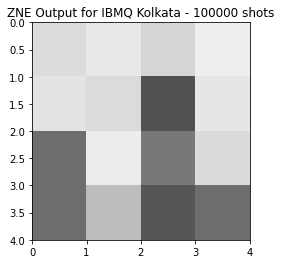

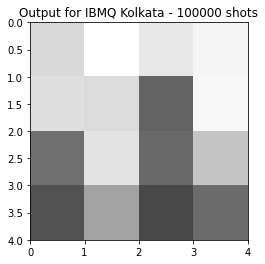

In [11]:
plot_image4x4_denormalized(np_zne_output, np_test_image, np_test_image_normalized, 'ZNE Output for IBMQ Kolkata - 100000 shots')
plot_image4x4_denormalized(np_kolkata_output, np_test_image, np_test_image_normalized, 'Output for IBMQ Kolkata - 100000 shots')

In [18]:
print("True Image:")
print(np_test_image)
print("IBMQ Kolkata:")
print(un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 4))
print("IBMQ Kolkata with ZNE:")
print(un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 4))

rmse_simulator = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_simulator_output, 4), 4)
rmse_kolkata = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 4), 4) 
rmse_zne = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 4), 4) 

print("Simulator error (100000 shots): ", (rmse_simulator * 100), "% per pixel")
print("IBMQ Kolkata error (100000 shots): ", (rmse_kolkata * 100), "% per pixel")
print("IMBQ Kolkata (with ZNE) error (100000 shots): ", (rmse_zne * 100), "% per pixel")

True Image:
[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]
IBMQ Kolkata:
[[0.84860135 1.00086268 0.90464431 0.95781419]
 [0.87156888 0.85587614 0.3879522  0.97071776]
 [0.43443324 0.89131198 0.41510638 0.7708179 ]
 [0.3192714  0.63464716 0.28170585 0.41859387]]
IBMQ Kolkata with ZNE:
[[0.86046379 0.9066008  0.83518182 0.93277405]
 [0.89330291 0.85781004 0.32218771 0.89870363]
 [0.42861175 0.92375435 0.47184888 0.85442838]
 [0.42658421 0.74035009 0.33840999 0.42851241]]
Simulator error (100000 shots):  0.4719698542319386 % per pixel
IBMQ Kolkata error (100000 shots):  2.850576277701329 % per pixel
IMBQ Kolkata (with ZNE) error (100000 shots):  1.6977685579889708 % per pixel


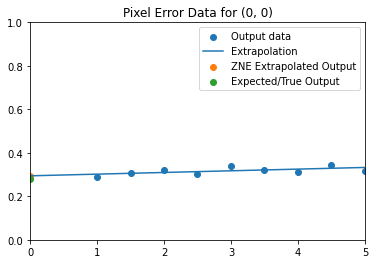

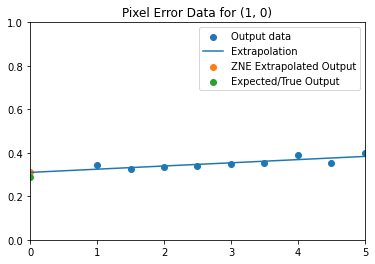

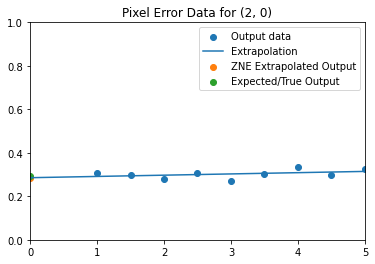

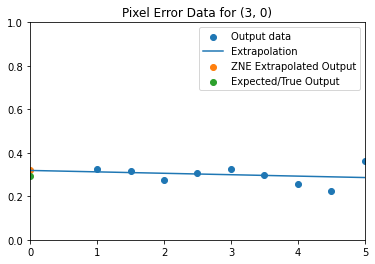

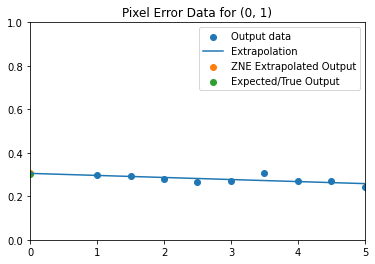

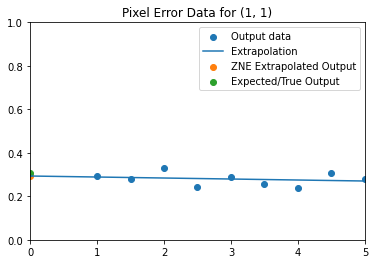

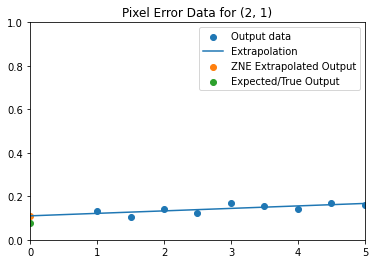

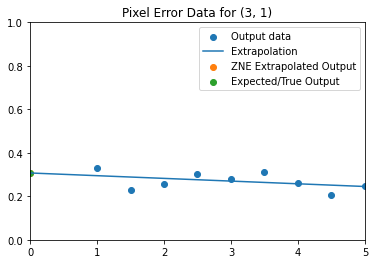

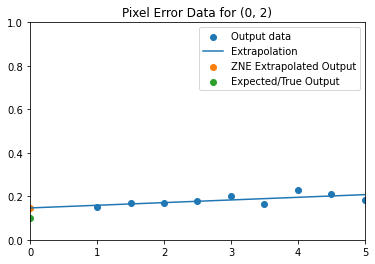

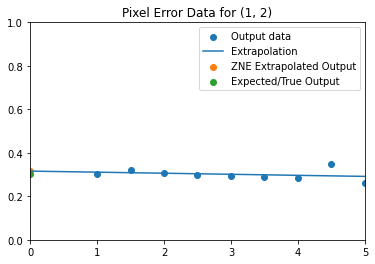

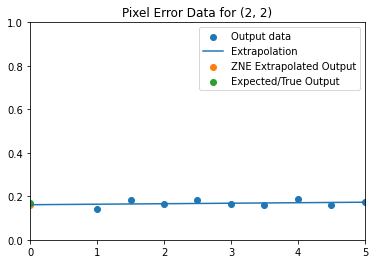

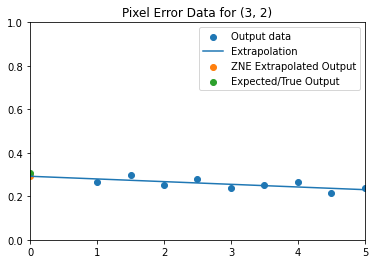

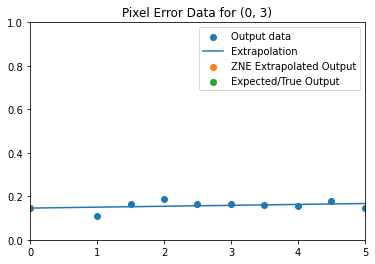

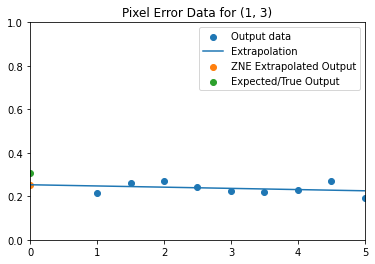

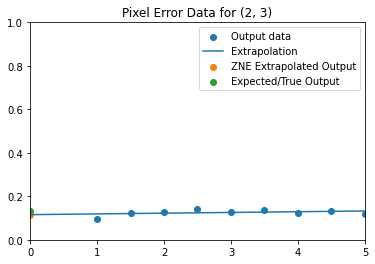

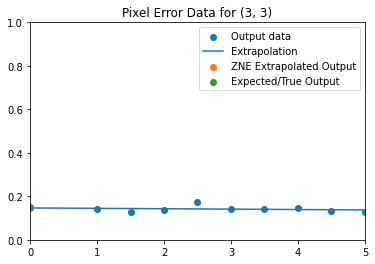

In [20]:
def linear_function(x, a, b):
    return a + (b * x)

def plot_pixel_error_linear(scale_factors, expectation_values, test_image_normalized, x, y, n):
    plt.xlim([0, 5])
    plt.ylim([0,1])

    scale_factors_fitted = np.linspace(0, 5, 100)

    plt.scatter(scale_factors, expectation_values[x + (y * n)], label="Output data")
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[x + (y * n)])
    
    scale_factors_fitted_output = []
    for x_output in scale_factors_fitted:
        scale_factors_fitted_output.append(linear_function(x_output, param[0], param[1]))
        
    np_scale_factors_fitted_output = np.array(scale_factors_fitted_output)
    plt.plot(scale_factors_fitted, np_scale_factors_fitted_output, label="Extrapolation" )

    plt.scatter(0, linear_function(0, param[0], param[1]), label="ZNE Extrapolated Output")
    plt.scatter(0, test_image_normalized[y][x], label="Expected/True Output")

    plt.title("Pixel Error Data for (" + str(x) + ", " + str(y) + ")")
    plt.legend()
    plt.show()


for y in range(4):
    for x in range(4):
        plot_pixel_error_linear(scale_factors, expectation_values, np_test_image_normalized, x, y, 4)